Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [2]:
## If you are using the data by mounting the google drive, use the following :
from google.colab import drive
drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

Mounted at /content/gdrive


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [3]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
root_path = 'gdrive/My Drive/CNN_assignment/'
data_dir_train = pathlib.Path(root_path+"Train")
data_dir_test = pathlib.Path(root_path+'Test')

In [4]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [5]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [6]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    validation_split = 0.2,
    subset = 'training',
    image_size = (img_width, img_height),
    seed = 123,
    batch_size = batch_size
)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [7]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    validation_split = 0.2,
    subset = 'validation',
    image_size = (img_width, img_height),
    seed = 123,
    batch_size = batch_size
)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [8]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

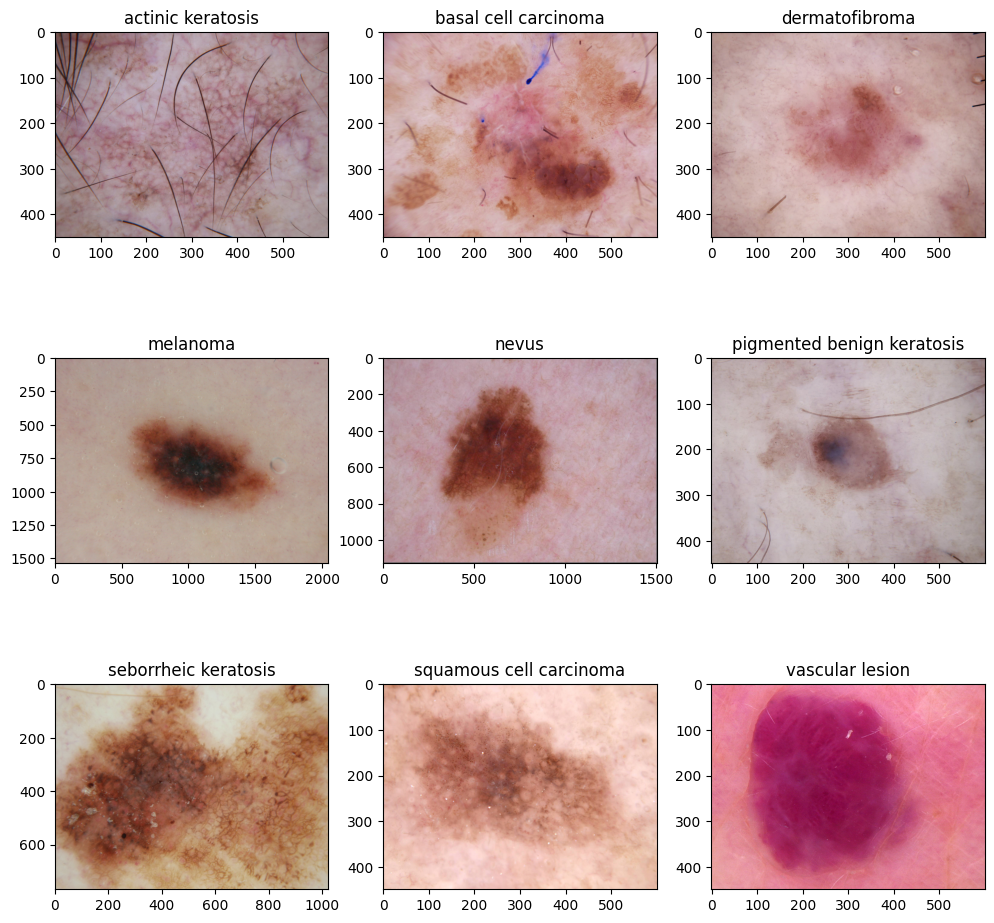

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize = (12,12))
for i in range(len(class_names)):
  plt.subplot(3, 3, i + 1)
  image = plt.imread(str(list(data_dir_train.glob(class_names[i]+'/*.jpg'))[1]))
  plt.title(class_names[i])
  plt.imshow(image)

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [10]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [11]:
from keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Dropout

num_classes = len(class_names)
model = Sequential([layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_width, img_height, 3))])
model.add(Conv2D(filters = 32, kernel_size = (4,4), input_shape = (img_width, img_height, 32), padding = 'same', activation = 'relu'))
model.add(Conv2D(filters = 32, kernel_size = (4,4), padding = 'same', activation = 'relu'))
model.add(MaxPool2D(pool_size = (2,2)))
model.add(Conv2D(filters = 32, kernel_size = (4,4), padding = 'same', activation = 'relu'))
model.add(MaxPool2D(pool_size = (2,2)))
model.add(Conv2D(filters = 64, kernel_size = (4,4), padding = 'same', activation = 'relu'))
model.add(MaxPool2D(pool_size = (2,2)))
model.add(Conv2D(filters = 64, kernel_size = (4,4), padding = 'same', activation = 'relu'))
model.add(MaxPool2D(pool_size = (2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(num_classes, activation = 'softmax'))

### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [12]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [13]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 32)      1568      
                                                                 
 conv2d_1 (Conv2D)           (None, 180, 180, 32)      16416     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 32)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 90, 90, 32)        16416     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                    

### Train the model

In [14]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20


/usr/local/lib/python3.9/dist-packages/keras/backend.py:5612: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


56/56 [==============================] - 235s 919ms/step - loss: 2.0335 - accuracy: 0.2282 - val_loss: 1.8946 - val_accuracy: 0.3110
Epoch 2/20
56/56 [==============================] - 6s 98ms/step - loss: 1.8479 - accuracy: 0.3170 - val_loss: 1.7606 - val_accuracy: 0.3781
Epoch 3/20
56/56 [==============================] - 5s 96ms/step - loss: 1.7121 - accuracy: 0.3739 - val_loss: 1.9097 - val_accuracy: 0.3221
Epoch 4/20
56/56 [==============================] - 5s 98ms/step - loss: 1.6790 - accuracy: 0.3996 - val_loss: 1.6447 - val_accuracy: 0.4116
Epoch 5/20
56/56 [==============================] - 5s 97ms/step - loss: 1.6003 - accuracy: 0.4319 - val_loss: 1.6052 - val_accuracy: 0.4228
Epoch 6/20
56/56 [==============================] - 6s 99ms/step - loss: 1.5864 - accuracy: 0.4314 - val_loss: 1.5540 - val_accuracy: 0.4676
Epoch 7/20
56/56 [==============================] - 6s 100ms/step - loss: 1.5178 - accuracy: 0.4604 - val_loss: 1.5753 - val_accuracy: 0.4474
Epoch 8/20
56/56 [==

### Visualizing training results

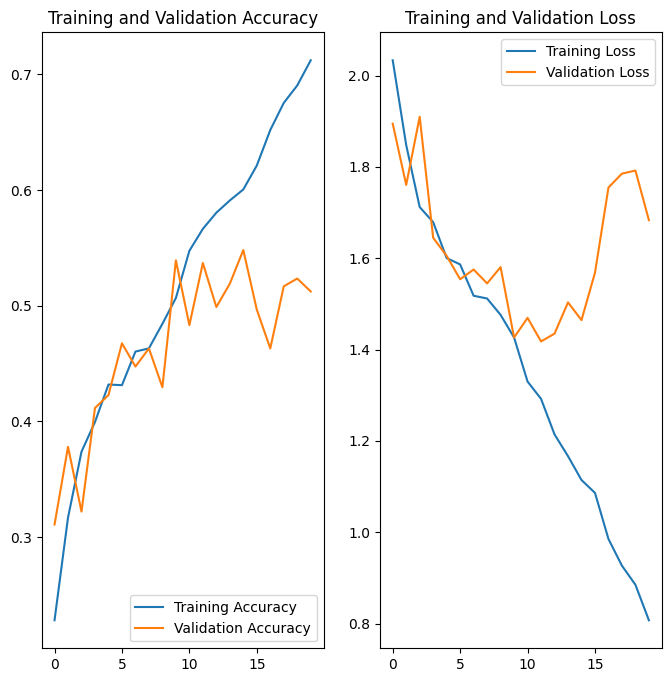

In [15]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Findings
##### Model seems to be overfitting as we can see accuracy on validation set is getting stuck at some point after 12th epoch, though training accuracy increases
##### Though we have sufficient amount of features to learn the pattern, accuracy on training set could go beyond 70%
##### Seems like we need to fine tune the model to increase training accuracy first and learn generic patterns so it doesn't overfit

In [16]:
augumented_data = keras.Sequential([layers.experimental.preprocessing.RandomFlip(mode = 'horizontal_and_vertical', input_shape = (img_width, img_height, 3)),
                                   layers.experimental.preprocessing.RandomRotation(0.2, fill_mode = 'reflect'),
                                   layers.experimental.preprocessing.RandomZoom(height_factor = (0.2, 0.3), width_factor = (0.2, 0.3), fill_mode = 'reflect')])

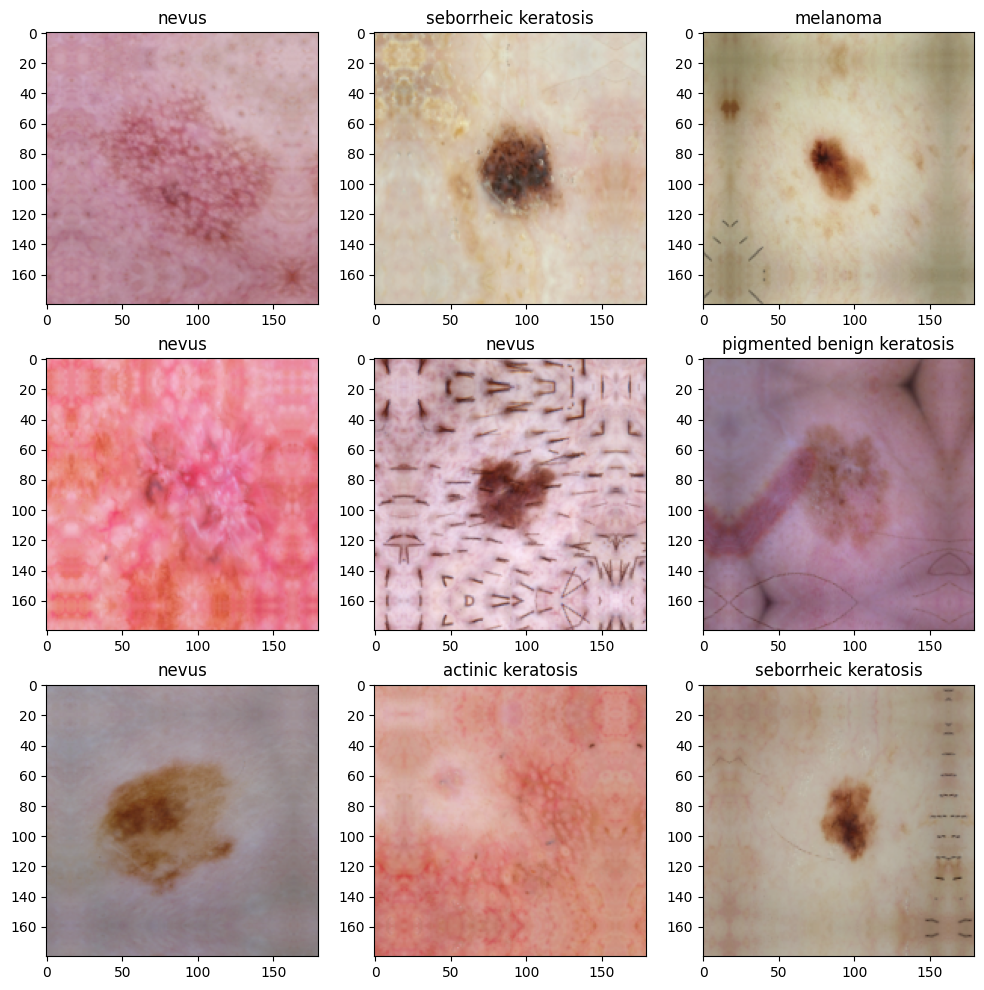

In [17]:
plt.figure(figsize = (12, 12))
for images, labels in train_ds.take(1):
  for i in range(len(class_names)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augumented_data(images)[i].numpy().astype('uint8'))
    plt.title(class_names[labels[i]])

### Todo:
### Create the model, compile and train the model


In [18]:
from keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Dropout

num_classes = len(class_names)
model = Sequential([augumented_data, layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_width, img_height, 3))])
model.add(Conv2D(filters = 32, kernel_size = (4,4), input_shape = (img_width, img_height, 32), padding = 'same', activation = 'relu'))
model.add(Conv2D(filters = 32, kernel_size = (4,4), padding = 'same', activation = 'relu'))
model.add(MaxPool2D(pool_size = (2,2)))
model.add(Conv2D(filters = 32, kernel_size = (4,4), padding = 'same', activation = 'relu'))
model.add(MaxPool2D(pool_size = (2,2)))
model.add(Conv2D(filters = 64, kernel_size = (4,4), padding = 'same', activation = 'relu'))
model.add(MaxPool2D(pool_size = (2,2)))
model.add(Conv2D(filters = 64, kernel_size = (4,4), padding = 'same', activation = 'relu'))
model.add(MaxPool2D(pool_size = (2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(num_classes, activation = 'softmax'))

### Compiling the model

In [19]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### Training the model

In [20]:
epochs = 30
history = model.fit(
    train_ds,
    validation_data = val_ds,
    epochs = epochs
)


Epoch 1/30
56/56 [==============================] - 8s 106ms/step - loss: 2.0568 - accuracy: 0.2003 - val_loss: 2.0243 - val_accuracy: 0.1924
Epoch 2/30
56/56 [==============================] - 6s 100ms/step - loss: 2.0432 - accuracy: 0.2070 - val_loss: 2.0356 - val_accuracy: 0.1924
Epoch 3/30
56/56 [==============================] - 6s 101ms/step - loss: 2.0223 - accuracy: 0.1842 - val_loss: 2.0278 - val_accuracy: 0.1924
Epoch 4/30
56/56 [==============================] - 6s 100ms/step - loss: 2.0308 - accuracy: 0.2048 - val_loss: 2.0189 - val_accuracy: 0.2058
Epoch 5/30
56/56 [==============================] - 6s 99ms/step - loss: 1.9859 - accuracy: 0.2188 - val_loss: 1.9469 - val_accuracy: 0.2975
Epoch 6/30
56/56 [==============================] - 6s 101ms/step - loss: 1.9023 - accuracy: 0.2885 - val_loss: 1.8992 - val_accuracy: 0.2595
Epoch 7/30
56/56 [==============================] - 6s 100ms/step - loss: 1.8707 - accuracy: 0.2801 - val_loss: 1.8531 - val_accuracy: 0.3132
Epoch 8

### Visualizing the results

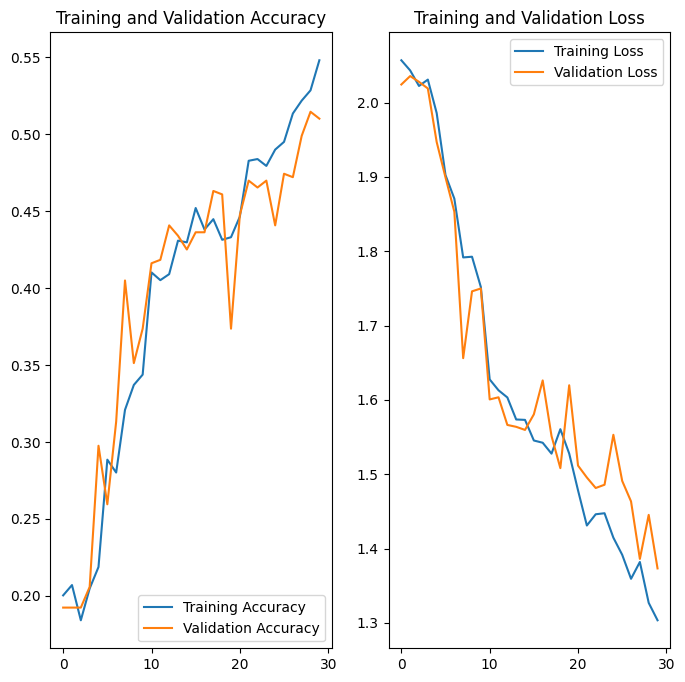

In [21]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Findings
#### Though we can see training accuracy has dropped down a lot, but definitely we've now solved overfitting problem using data augumentation
#### If we alter the number of epochs, we can see that as soon as we increase epochs by bit, accuracy is getting increased

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


<BarContainer object of 9 artists>

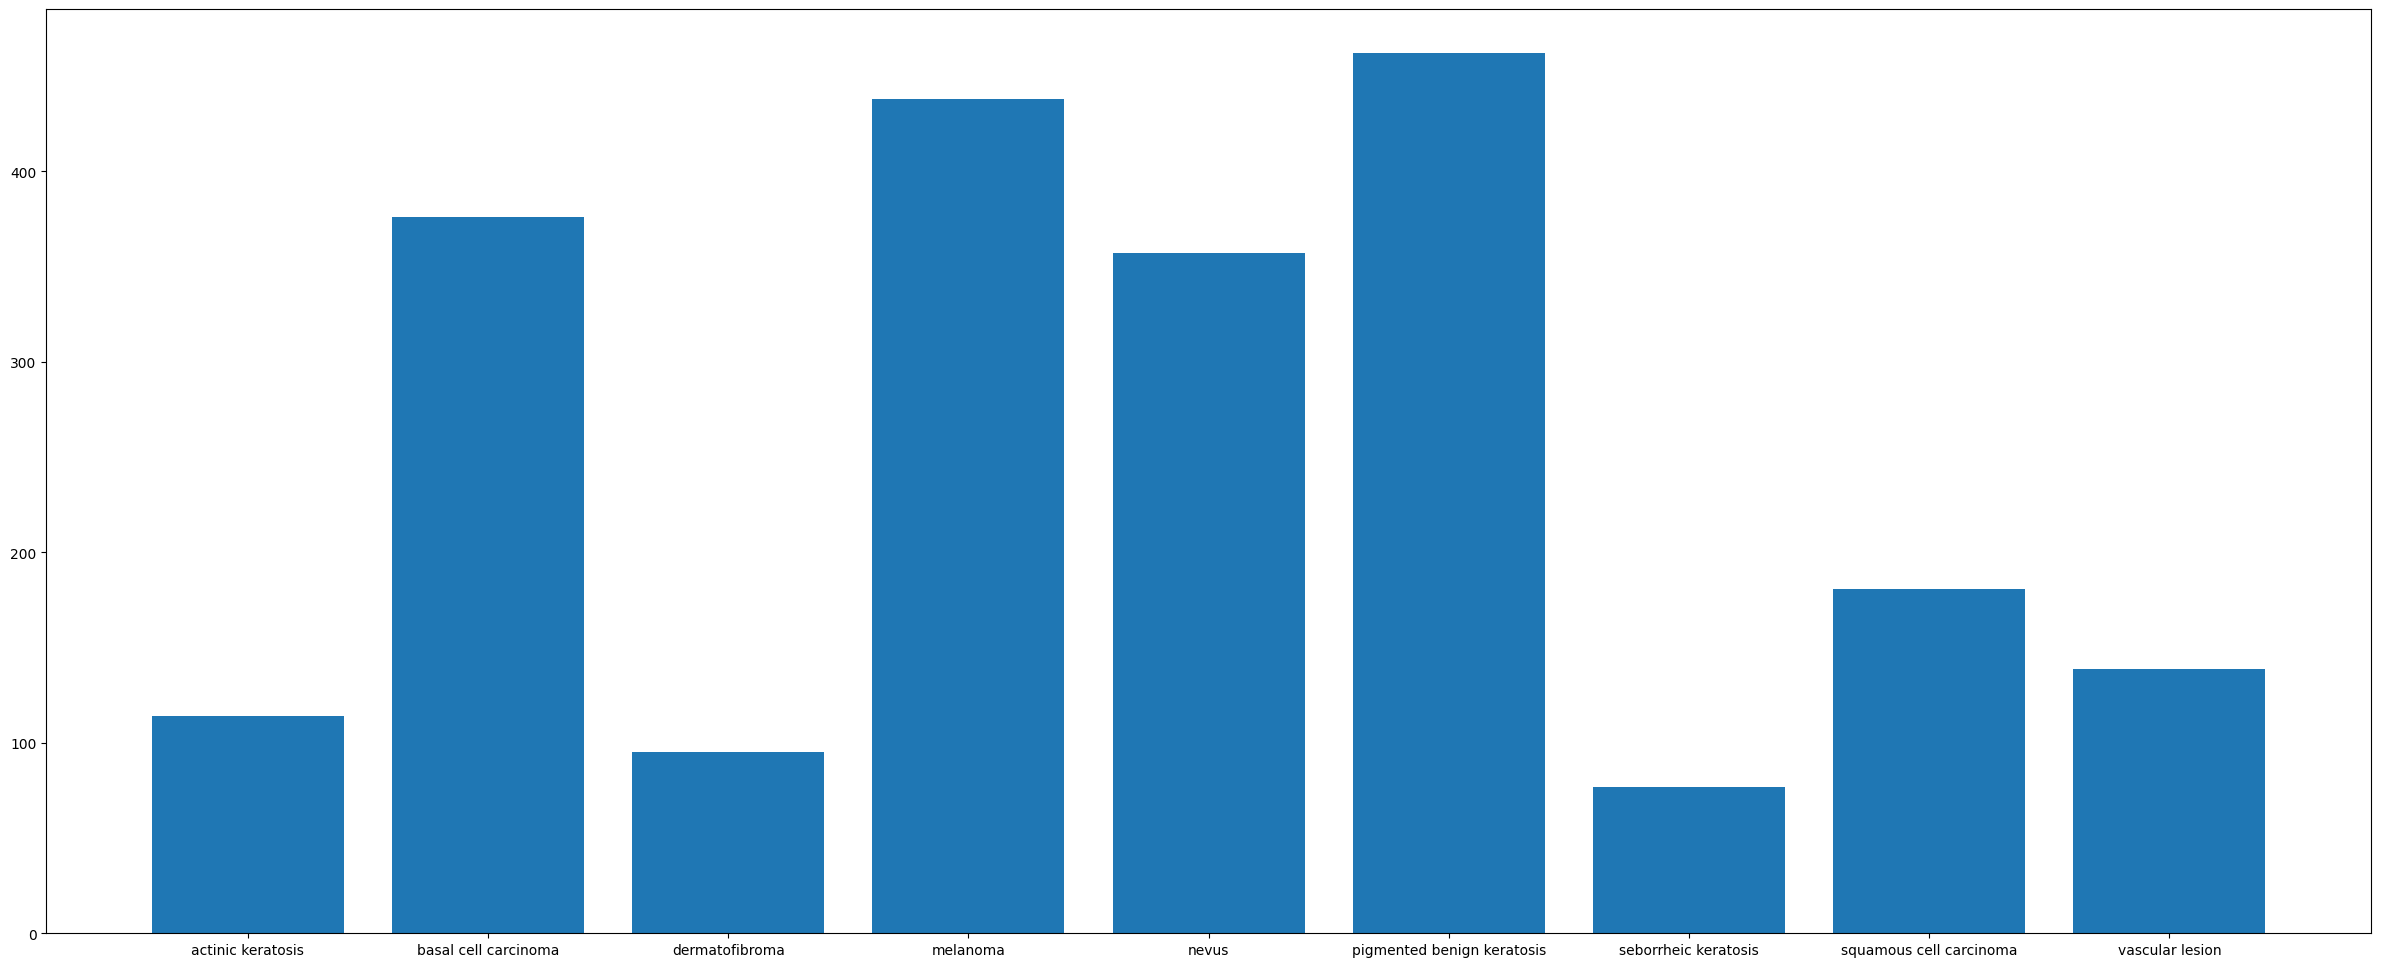

In [22]:
import os

count = []
print(os.listdir(data_dir_train))
dir_train = os.listdir(data_dir_train)
for class_name in dir_train:
  files = str(data_dir_train)+'/'+class_name
  count.append(len(os.listdir(files)))

plt.figure(figsize = (30, 12))
plt.bar(dir_train, count)

#### Which class has the least number of samples?
 ##### -> As we can see 'seborrheic keratosis' has least number of samples
#### Which classes dominate the data in terms proportionate number of samples?
 ##### -> 'melanoma' and 'pigmented benign keratosis' have proportionate number of samples and dominate the datd


#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [23]:
!pip install Augmentor

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [24]:
str(data_dir_train)

'gdrive/My Drive/CNN_assignment/Train'

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [25]:
path_to_training_dataset="/content/gdrive/My Drive/CNN_assignment/Train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/gdrive/My Drive/CNN_assignment/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F133005ED00>: 100%|██████████| 500/500 [00:26<00:00, 19.05 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/gdrive/My Drive/CNN_assignment/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F1330702760>: 100%|██████████| 500/500 [00:23<00:00, 20.88 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/gdrive/My Drive/CNN_assignment/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F13303AE6A0>: 100%|██████████| 500/500 [00:26<00:00, 18.74 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/gdrive/My Drive/CNN_assignment/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F1330090F40>: 100%|██████████| 500/500 [01:51<00:00,  4.47 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/gdrive/My Drive/CNN_assignment/Train/nevus/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F12BC137AC0>: 100%|██████████| 500/500 [01:37<00:00,  5.11 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/gdrive/My Drive/CNN_assignment/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F12BC1208B0>: 100%|██████████| 500/500 [00:22<00:00, 22.50 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/gdrive/My Drive/CNN_assignment/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F12BC15DBE0>: 100%|██████████| 500/500 [00:48<00:00, 10.24 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/gdrive/My Drive/CNN_assignment/Train/squamous cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F13300D61C0>: 100%|██████████| 500/500 [00:23<00:00, 21.36 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/gdrive/My Drive/CNN_assignment/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F134C098940>: 100%|██████████| 500/500 [00:20<00:00, 24.04 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [26]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4472


### Lets see the distribution of augmented data after adding new images to the original training data.

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


<BarContainer object of 9 artists>

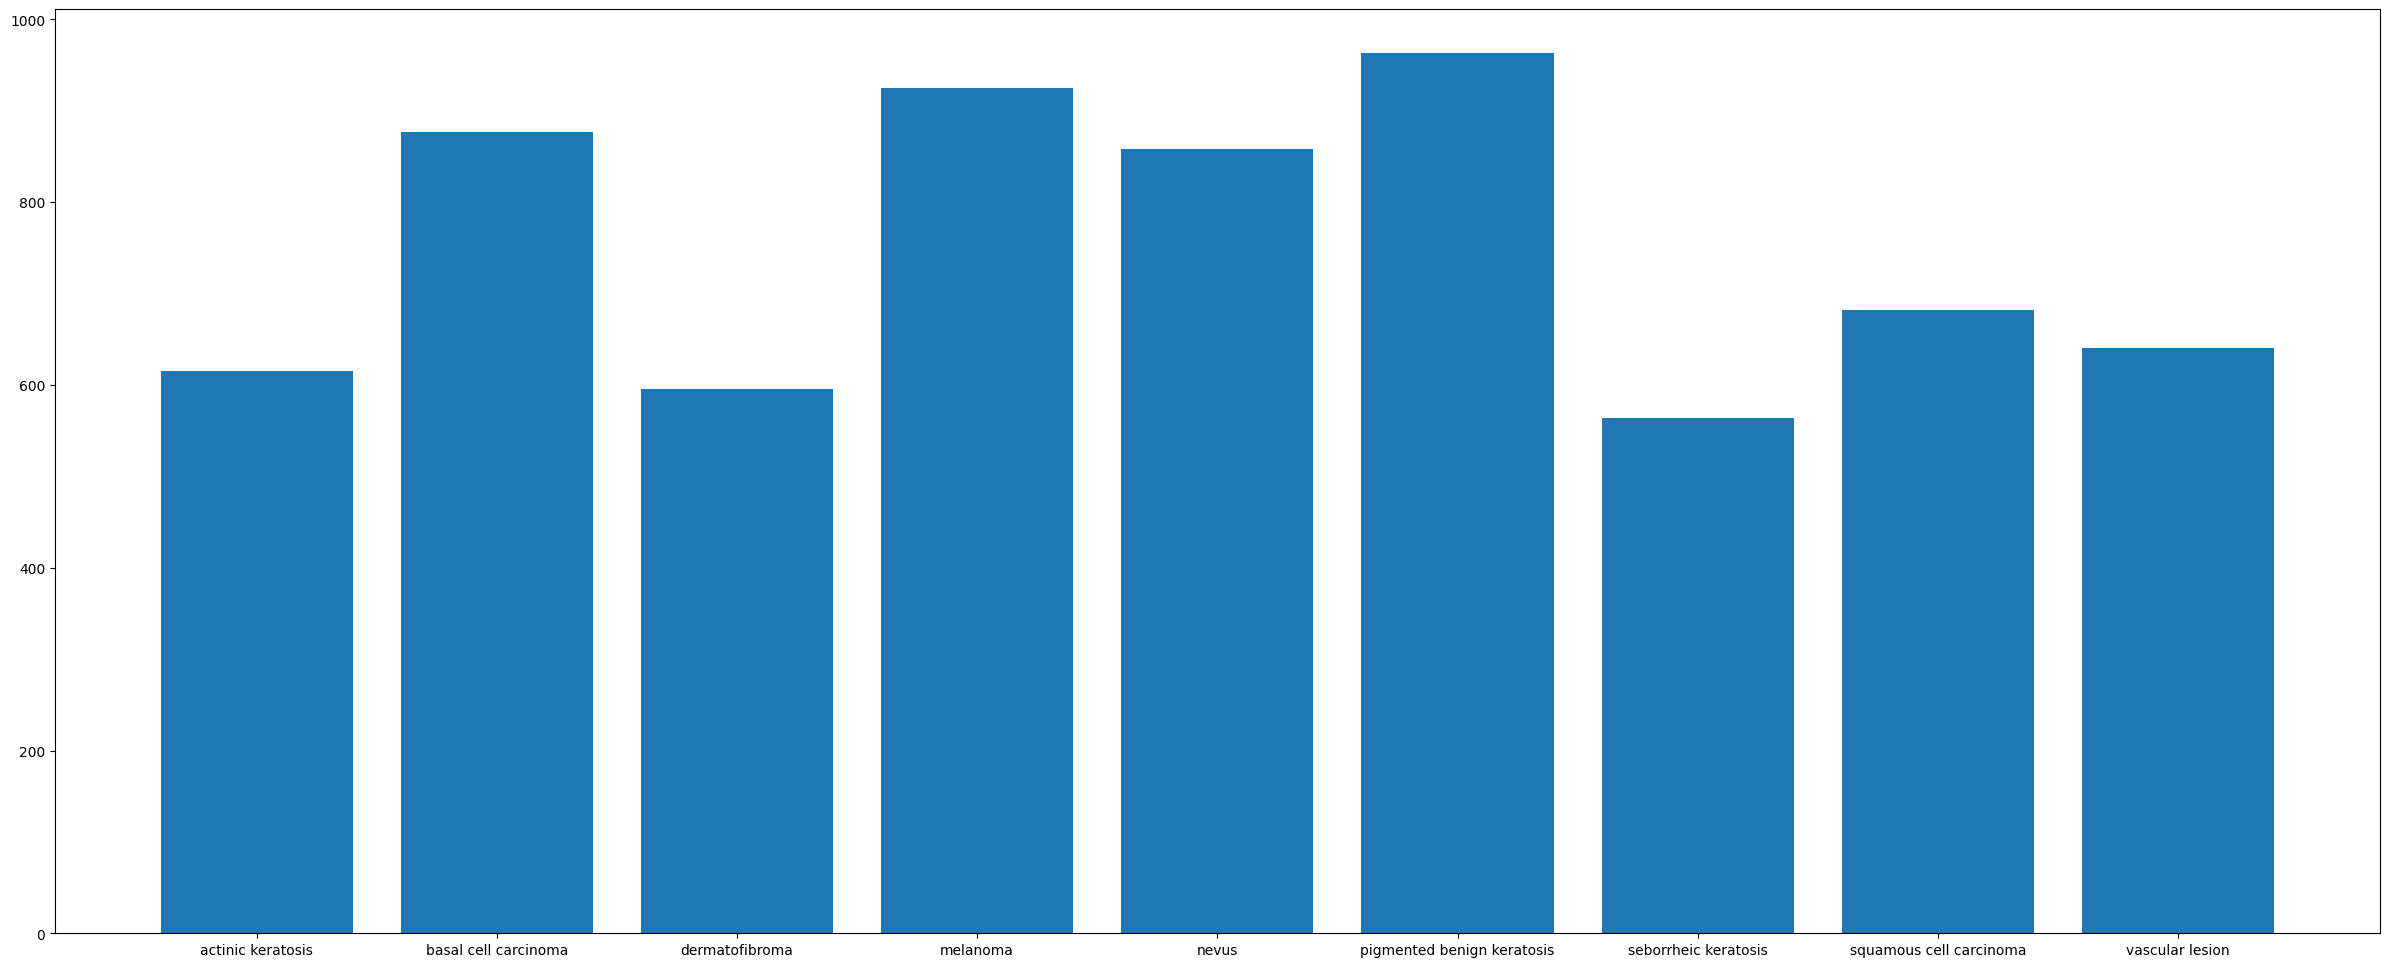

In [31]:
count = []
print(os.listdir(data_dir_train))
dir_train = os.listdir(data_dir_train)
for class_name in dir_train:
  files = str(data_dir_train)+'/'+class_name
  new_files = str(data_dir_train)+'/'+class_name + '/output'
  count.append(len(os.listdir(files)) + len(os.listdir(new_files)))

plt.figure(figsize = (30, 12))
plt.bar(dir_train, count)

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [33]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [35]:
data_dir_train="/content/gdrive/My Drive/CNN_assignment/Train/"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6711 files belonging to 9 classes.
Using 5369 files for training.


#### **Todo:** Create a validation dataset

In [36]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6711 files belonging to 9 classes.
Using 1342 files for validation.


#### **Todo:** Create your model (make sure to include normalization)

In [37]:
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
num_classes = 9
model = Sequential([ 
                    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width,3))
      
])
model.add(Conv2D(filters = 32, kernel_size = (4,4),padding = 'same', 
                 activation ='relu', input_shape = (180, 180, 32)))
model.add(Conv2D(filters = 32, kernel_size = (4,4),padding = 'same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 32, kernel_size = (4,4),padding = 'same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 64, kernel_size = (4,4),padding = 'same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 64, kernel_size = (4,4),padding = 'same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(num_classes, activation = "softmax"))

#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [39]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

#### **Todo:**  Train your model

In [40]:
#epochs = 30
## Your code goes here, use 50 epochs.
epochs = 50

history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/50


/usr/local/lib/python3.9/dist-packages/keras/backend.py:5612: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


168/168 [==============================] - 47s 254ms/step - loss: 2.1609 - accuracy: 0.1538 - val_loss: 2.0748 - val_accuracy: 0.1855
Epoch 2/50
168/168 [==============================] - 38s 217ms/step - loss: 1.9483 - accuracy: 0.2416 - val_loss: 1.8837 - val_accuracy: 0.2809
Epoch 3/50
168/168 [==============================] - 36s 209ms/step - loss: 1.7519 - accuracy: 0.3239 - val_loss: 1.7117 - val_accuracy: 0.3592
Epoch 4/50
168/168 [==============================] - 38s 212ms/step - loss: 1.6436 - accuracy: 0.3727 - val_loss: 1.7894 - val_accuracy: 0.2943
Epoch 5/50
168/168 [==============================] - 38s 219ms/step - loss: 1.4518 - accuracy: 0.4647 - val_loss: 1.4115 - val_accuracy: 0.4814
Epoch 6/50
168/168 [==============================] - 41s 235ms/step - loss: 1.2581 - accuracy: 0.5424 - val_loss: 1.2735 - val_accuracy: 0.5410
Epoch 7/50
168/168 [==============================] - 40s 233ms/step - loss: 1.0762 - accuracy: 0.6161 - val_loss: 1.1530 - val_accuracy: 0.5

#### **Todo:**  Visualize the model results

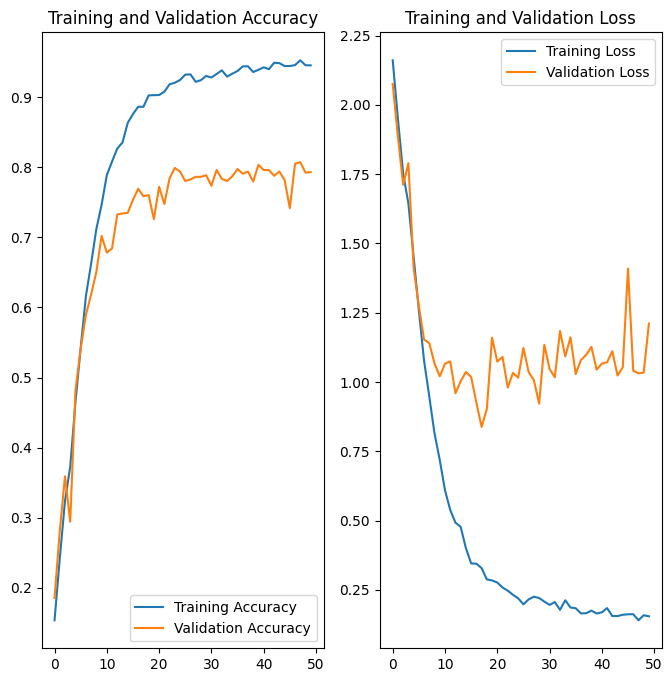

In [41]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?

## After we generated new set of images using augmentor, we can see that training accuracy is increased by lot
## But we can still see, there's lot of gap between training accuracy and validation accuracy, so we can conclude that problem of overfitting is not yet resolved
## We need to fine tune the hyperparameters, such as number of layers, dropout layers or maybe fine tune the number of neurons
